<a href="https://colab.research.google.com/github/mohamedghaly1/ECG-Detection-Using-EGRU/blob/main/LSTM%20and%20GRU%20models/LSTM_GRU_model_ECG_ARRHYHMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset/

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
!ls

kaggle.json


In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
 96% 95.0M/98.8M [00:00<00:00, 201MB/s]
100% 98.8M/98.8M [00:00<00:00, 193MB/s]


In [ ]:
!mkdir heartbeat
!mv heartbeat.zip heartbeat

In [ ]:
%cd heartbeat/

/content/gdrive/MyDrive/kaggle_dataset/heartbeat


In [ ]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
%cd /content

/content


In [ ]:
!pip install eco2ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.8.0 requires pandas>=1.5.0, but you have pandas 1.4.3 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.4.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.4.3 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.4.3 whic

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import eco2ai
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Preprocessing & Exploring The Data

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_train.csv",header=None)
test_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_test.csv",header=None)
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


**Sampling**

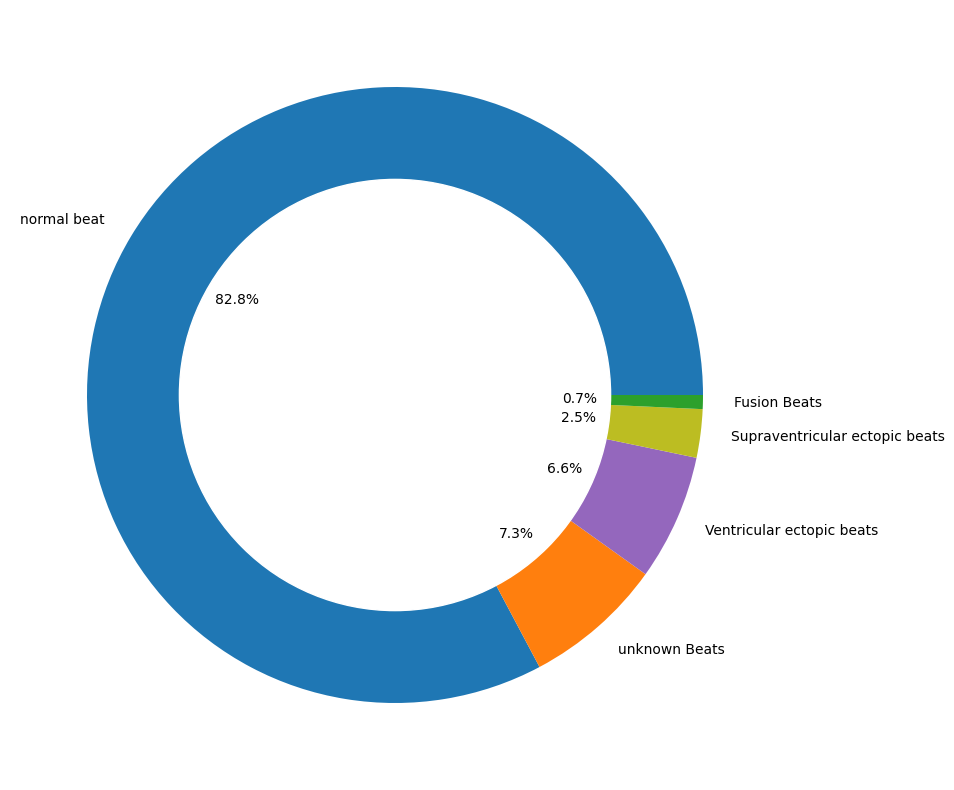

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Oversampling / SMOTE Sampling**

In [ ]:
from sklearn.utils import resample
df_1=train_df [train_df [187]==1]
df_2=train_df [train_df [187]==2]
df_3=train_df [train_df[187]==3]
df_4=train_df [train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=65000,random_state=42)
train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])

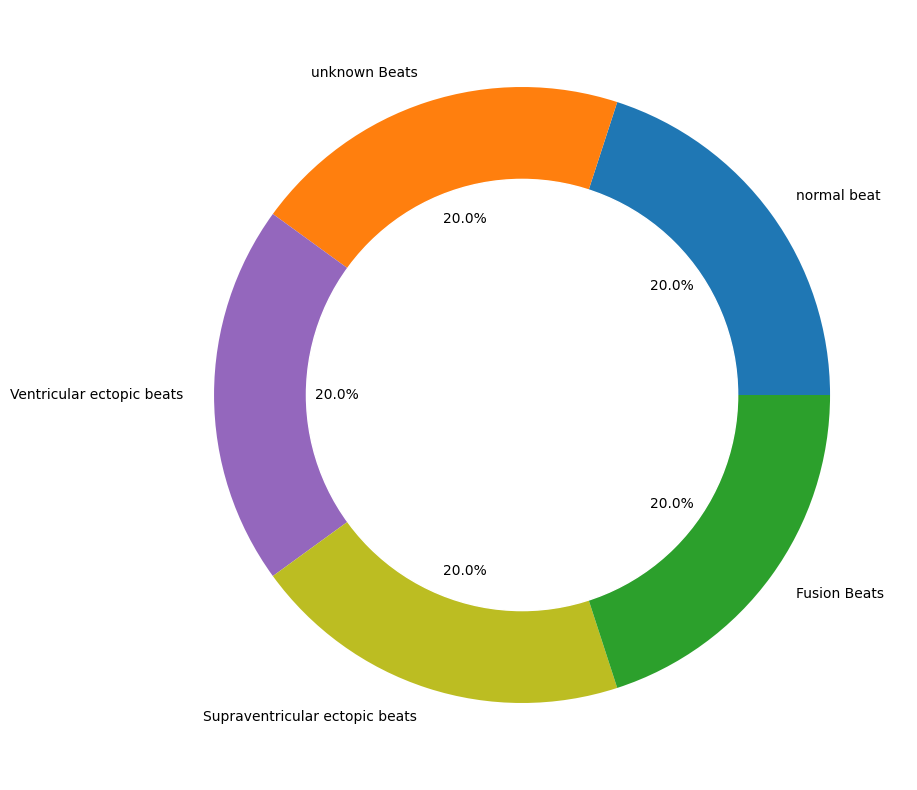

0.0    65000
1.0    65000
2.0    65000
3.0    65000
4.0    65000
Name: 187, dtype: int64


In [ ]:
# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

**Plotting**

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

classes:              0         1         2         3         4         5         6    \
33788   1.000000  0.752336  0.528037  0.313084  0.135514  0.158879  0.266355   
96988   0.971133  0.776075  0.436724  0.167674  0.095240  0.167247  0.204772   
198834  0.746028  0.695121  0.422634  0.180602  0.073753  0.011179  0.000000   
207652  1.000000  0.810577  0.523303  0.223459  0.103122  0.144675  0.142949   
316083  0.941157  0.892360  0.820357  0.770004  0.707883  0.642720  0.559066   

             7         8         9    ...  178  179  180  181  182  183  184  \
33788   0.369159  0.350467  0.387850  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96988   0.187304  0.178772  0.180206  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
198834  0.040180  0.118814  0.199365  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
207652  0.118264  0.099205  0.095844  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
316083  0.486804  0.424425  0.371643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        185  186  187  
33788

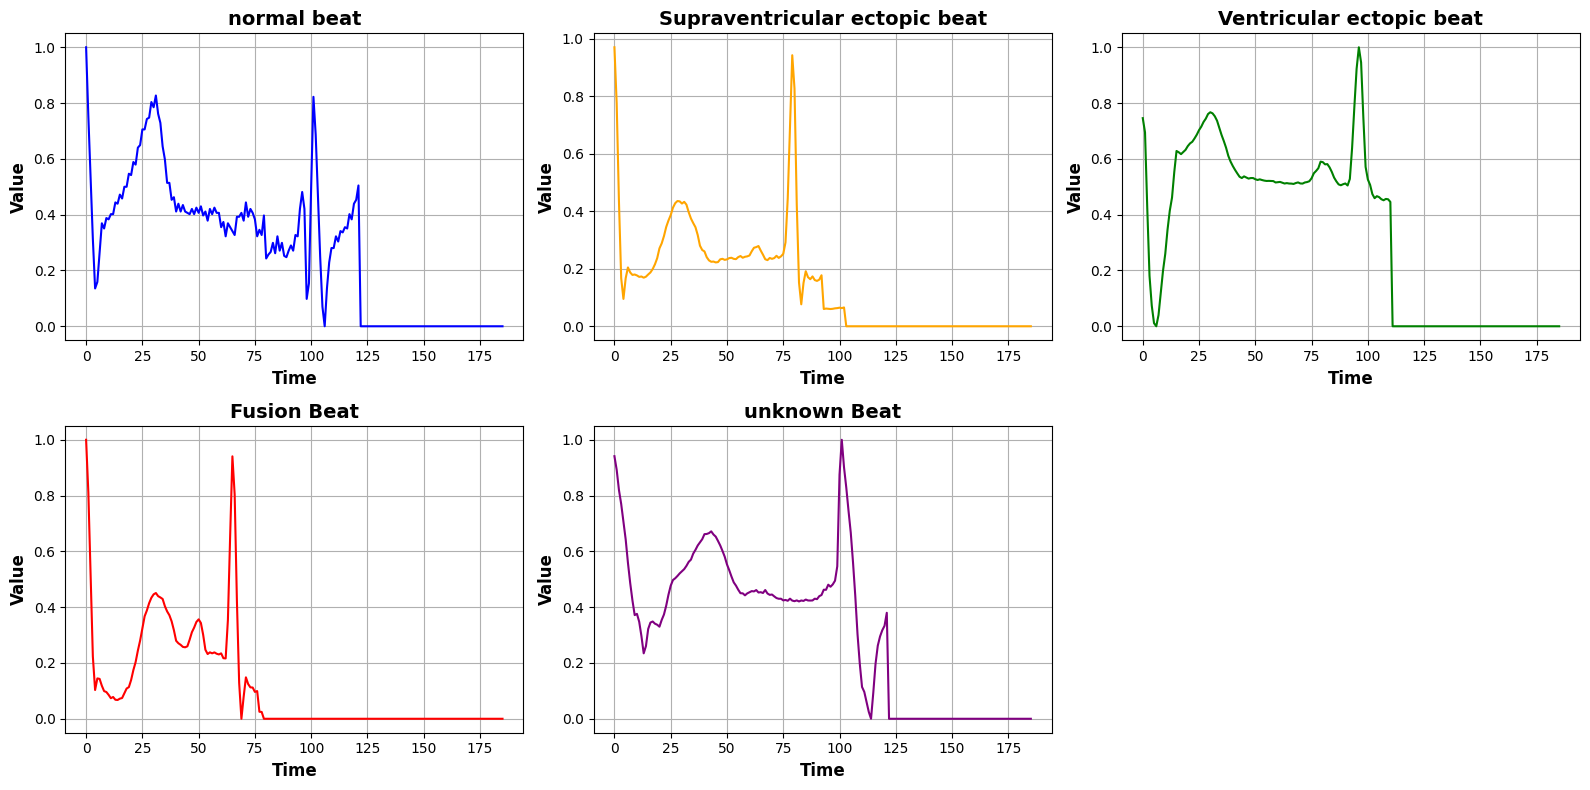

In [ ]:
# Define custom colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(16, 8))

class_labels = ['normal beat', 'Supraventricular ectopic beat', 'Ventricular ectopic beat',
                'Fusion Beat','unknown Beat']

for i, label in enumerate(class_labels, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=classes.iloc[i-1, :186], color=colors[i-1])
    plt.title(label, fontsize=14, fontweight='bold')

    # Set labels and ticks
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Value', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

plt.tight_layout()
plt.show()

**Getting the Data**

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

## **Model 1 (using LSTM)**

**LSTM Network**

In [ ]:
def lstm_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')
    lstm1 = LSTM(128, return_sequences=True)(inputs_lstm)
    lstm1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(64, return_sequences=True)(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm3 = LSTM(32)(lstm2)
    lstm3 = BatchNormalization()(lstm3)
    dense_end1 = Dense(32, activation='relu')(lstm3)
    # dense_end1 = Dropout(0.2)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    # dense_end2 = Dropout(0.2)(dense_end2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model_lstm.h5')
    return model, history


**LSTM Evaluation**

In [ ]:
def lstm_evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid(True)
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

**Initialize eco2ai Tracker for estimating the Power Consumption and CO2 Emission**

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
lstm_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification", file_name="lstm_emission.csv")

**Train the LSTM model**

In [ ]:
lstm_tracker.start()
start_time = time.time()
model,history=lstm_network(X_train,y_train,X_test,y_test)
current_time = time.time()
lstm_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1/20
10157/10157 [==============================] - 330s 31ms/step - loss: 0.4216 - accuracy: 0.8438 - val_loss: 0.4363 - val_accuracy: 0.8526
Epoch 2/20
10157/10157 [==============================] - 314s 31ms/step - loss: 0.1573 - accuracy: 0.9475 - val_loss: 0.2050 - val_accuracy: 0.9331
Epoch 3/20
10157/10157 [==============================] - 314s 31ms/step - loss: 0.1088 - accuracy: 0.9644 - val_loss: 0.2320 - val_accuracy: 0.9202
Epoch 4/20
10157/10157 [==============================] - 309s 30ms/step - loss: 0.0846 - accuracy: 0.9729 - val_loss: 0.1316 - val_accuracy: 0.9604
Epoch 5/20
10157/10157 [==============================] - 310s 30ms/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.1283 - val_accuracy: 0.9565
Epoch 6/20
10157/10157 [==============================] - 304s 30ms/step - loss: 0.0630 - accuracy: 0.9803 - val_loss: 0.2076 - val_accuracy: 0.9366
Epoch 7/20
10157/10157 [==============================] - 307s 30ms/step - loss: 0.0562 - accuracy: 0.9824

**Evaluate the LSTM model**

Accuracy: 97.90%


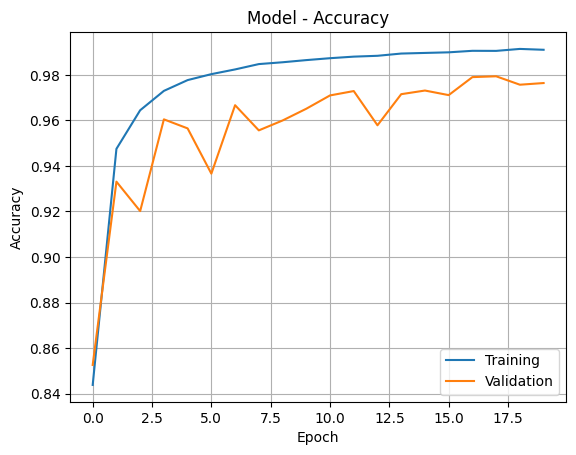

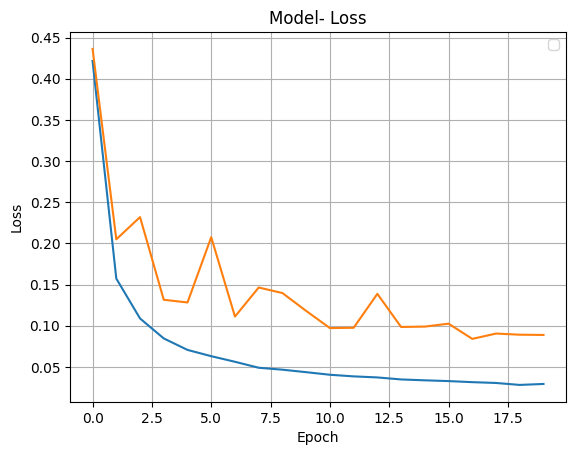

685/685 [==============================] - 7s 10ms/step


In [ ]:
lstm_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

**Reviewing the Power Consumption and CO2 emission**

In [ ]:
df = pd.read_csv('lstm_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,9eb1ece2-ad1d-4b4a-a975-e1d4ec6fc8c8,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-06-04 21:50:40,5798.960598,0.339148,0.133664,"Intel(R) Xeon(R) CPU @ 2.00GHz/1 device(s), TD...",Tesla T4 1 device(s),Linux,NL/Groningen,0


## **Model 2 (using GRU)**

**GRU Network**

In [ ]:
def gru_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_gru = Input(shape=(im_shape), name='inputs_gru')
    gru1 = GRU(128, return_sequences=True)(inputs_gru)
    gru1 = BatchNormalization()(gru1)
    gru2 = GRU(64, return_sequences=True)(gru1)
    gru2 = BatchNormalization()(gru2)
    gru3 = GRU(32)(gru2)
    gru3 = BatchNormalization()(gru3)
    dense_end1 = Dense(32, activation='relu')(gru3)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_gru, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model_gru.h5')

    return model, history

**GRU Evaluation**

In [ ]:
def gru_evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    print(history)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['accuracy'], label='Training')
    sns.lineplot(data=history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['loss'], label='Training')
    sns.lineplot(data=history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate confusion matrix
    y_true = [np.argmax(element) for element in y_test]
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

    # Normalize confusion matrix
    normalized_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cnf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
gru_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification",file_name="gru_emission.csv")

In [ ]:
gru_tracker.start()
start_time = time.time()
model, history = gru_network(X_train, y_train, X_test, y_test)
current_time = time.time()
gru_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1/20
10157/10157 [==============================] - 269s 25ms/step - loss: 0.2913 - accuracy: 0.8936 - val_loss: 0.8370 - val_accuracy: 0.6858
Epoch 2/20
10157/10157 [==============================] - 240s 24ms/step - loss: 0.1130 - accuracy: 0.9620 - val_loss: 0.3798 - val_accuracy: 0.8637
Epoch 3/20
10157/10157 [==============================] - 240s 24ms/step - loss: 0.0813 - accuracy: 0.9733 - val_loss: 0.4219 - val_accuracy: 0.8657
Epoch 4/20
10157/10157 [==============================] - 246s 24ms/step - loss: 0.0669 - accuracy: 0.9782 - val_loss: 0.1581 - val_accuracy: 0.9504
Epoch 5/20
10157/10157 [==============================] - 245s 24ms/step - loss: 0.0565 - accuracy: 0.9815 - val_loss: 0.1334 - val_accuracy: 0.9593
Epoch 6/20
10157/10157 [==============================] - 247s 24ms/step - loss: 0.0518 - accuracy: 0.9832 - val_loss: 0.1464 - val_accuracy: 0.9550
Epoch 7/20
10157/10157 [==============================] - 247s 24ms/step - loss: 0.0479 - accuracy: 0.9846

Accuracy: 98.01%


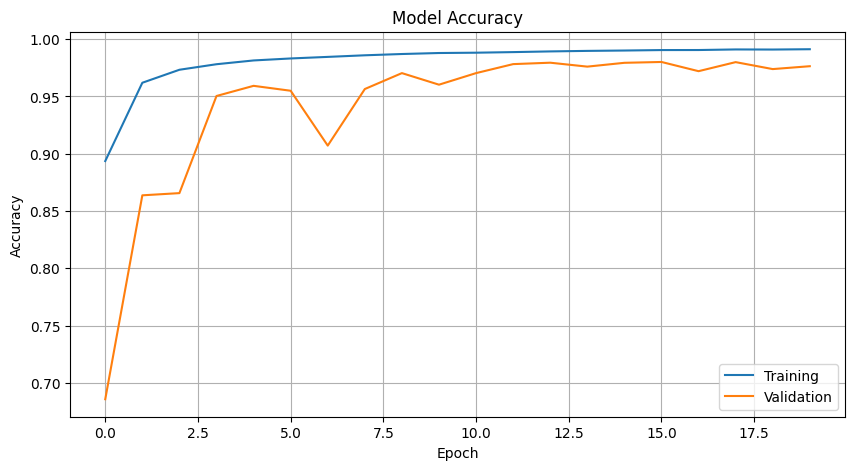

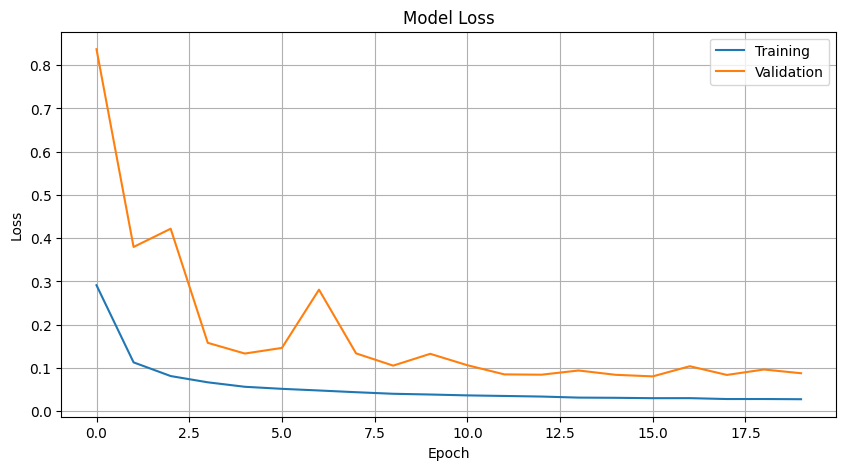

685/685 [==============================] - 8s 10ms/step


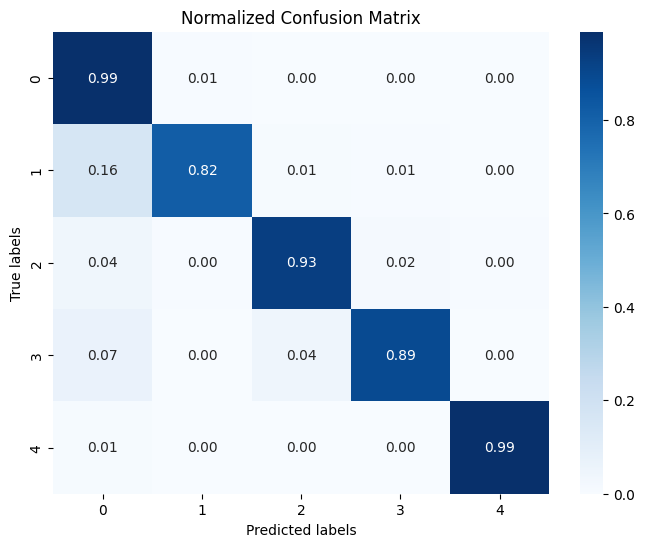

685/685 [==============================] - 6s 9ms/step


In [ ]:
gru_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [ ]:
df = pd.read_csv('gru_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,50b140ba-0a60-4fa1-bb82-2ccf8cc5b939,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-06-07 10:53:26,4963.771437,0.29216,0.052761,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",Tesla T4 1 device(s),Linux,US/Oregon,0
